📊 Simplified Delta Analyzer Ready!

Key Functions:
- test_analyzer(): Test API connection
- analyze_symbol_delta('AAPL'): Analyze current delta patterns
- analyze_symbol_delta('AAPL', '2024-01-15'): Analyze specific date
- analyze_delta_trend('AAPL', 3): Analyze trend over 3 periods
📊 Fetching historical options data for AAPL...
✅ Retrieved 2398 options contracts
✅ Analyzer ready - found 2398 options contracts
🎯 DELTA ANALYSIS FOR AAPL
📊 Fetching historical options data for AAPL...
✅ Retrieved 2398 options contracts
🔍 Analyzing delta patterns...


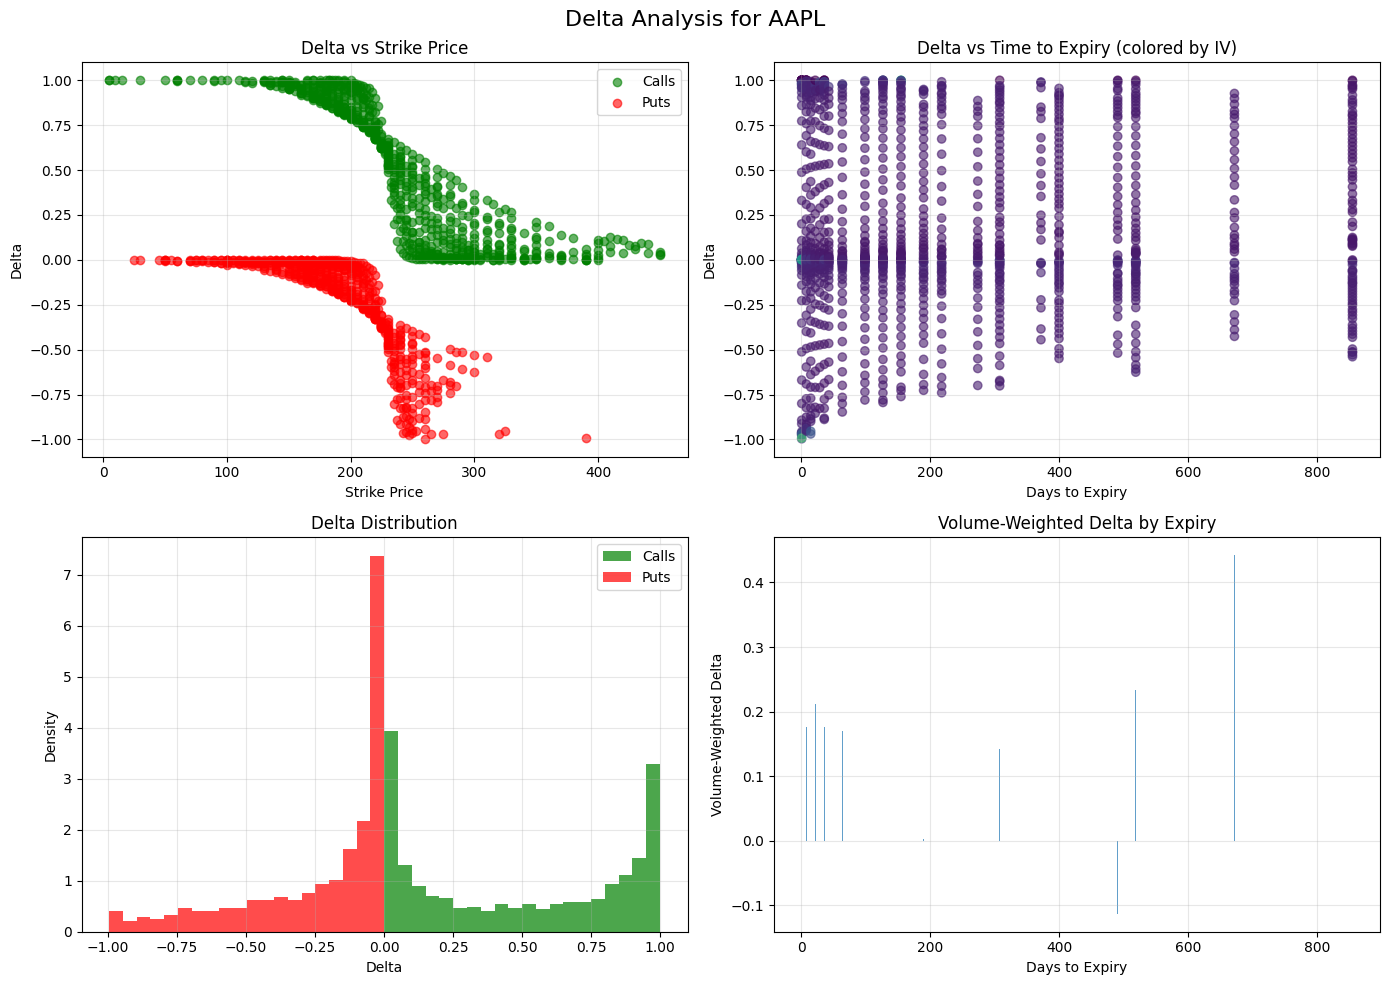


📋 DELTA ANALYSIS SUMMARY
Total Options Analyzed: 1,244
Calls: 688 | Puts: 556
Average Call Delta: 0.4974
Average Put Delta: -0.2353
Delta-IV Correlation: -0.0331
Volume-Weighted Delta: 0.1961

💡 KEY INSIGHTS
------------------------------
• Weak correlation between delta and implied volatility

🔥 MOST ACTIVE OPTIONS (by volume):
• CALL $230.0 - Delta: 0.488, Volume: 136,087
• CALL $235.0 - Delta: 0.200, Volume: 61,777
• CALL $232.5 - Delta: 0.331, Volume: 43,577
• CALL $270.0 - Delta: 0.172, Volume: 40,351
• CALL $235.0 - Delta: 0.309, Volume: 32,325


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta
import time

# Load environment variables
load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

class SimplifiedDeltaAnalyzer:
    """Simplified analyzer using Alpha Vantage Historical Options API for real delta data"""
    
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"
    
    def get_historical_options_data(self, symbol, date=None):
        """Get historical options data with real delta values"""
        print(f"📊 Fetching historical options data for {symbol}...")
        
        params = {
            'function': 'HISTORICAL_OPTIONS',
            'symbol': symbol,
            'apikey': self.api_key
        }
        
        if date:
            params['date'] = date
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if "Error Message" in data:
                print(f"❌ API Error: {data['Error Message']}")
                return None
            if "Note" in data:
                print(f"⚠️ API Note: {data['Note']}")
                return None
            
            # Parse the options data
            if 'data' not in data:
                print("❌ No options data found")
                return None
            
            options_list = []
            for option in data['data']:
                options_list.append({
                    'symbol': option.get('symbol', ''),
                    'type': option.get('type', ''),
                    'expiration': option.get('expiration', ''),
                    'strike': float(option.get('strike', 0)),
                    'last': float(option.get('last', 0)),
                    'bid': float(option.get('bid', 0)),
                    'ask': float(option.get('ask', 0)),
                    'volume': int(option.get('volume', 0)),
                    'open_interest': int(option.get('open_interest', 0)),
                    'implied_volatility': float(option.get('implied_volatility', 0)),
                    'delta': float(option.get('delta', 0)),
                    'gamma': float(option.get('gamma', 0)),
                    'theta': float(option.get('theta', 0)),
                    'vega': float(option.get('vega', 0))
                })
            
            df = pd.DataFrame(options_list)
            print(f"✅ Retrieved {len(df)} options contracts")
            return df
            
        except Exception as e:
            print(f"❌ Error fetching options data: {e}")
            return None
    
    def analyze_delta_patterns(self, options_df):
        """Analyze delta patterns from real options data"""
        if options_df is None or options_df.empty:
            return None
        
        print("🔍 Analyzing delta patterns...")
        
        # Filter for liquid options (volume > 0)
        liquid_options = options_df[options_df['volume'] > 0].copy()
        
        # Calculate days to expiration
        liquid_options['expiration_date'] = pd.to_datetime(liquid_options['expiration'])
        today = datetime.now()
        liquid_options['days_to_expiry'] = (liquid_options['expiration_date'] - today).dt.days
        
        # Calculate moneyness (assuming current stock price from ATM options)
        atm_strike = liquid_options.loc[liquid_options['delta'].abs().idxmin(), 'strike']
        liquid_options['moneyness'] = liquid_options['strike'] / atm_strike
        
        # Separate calls and puts
        calls = liquid_options[liquid_options['type'] == 'call']
        puts = liquid_options[liquid_options['type'] == 'put']
        
        analysis = {
            'total_options': len(liquid_options),
            'total_calls': len(calls),
            'total_puts': len(puts),
            'avg_call_delta': calls['delta'].mean(),
            'avg_put_delta': puts['delta'].mean(),
            'delta_volatility_corr': liquid_options['delta'].corr(liquid_options['implied_volatility']),
            'volume_weighted_delta': (liquid_options['delta'] * liquid_options['volume']).sum() / liquid_options['volume'].sum()
        }
        
        return liquid_options, analysis
    
    def plot_delta_analysis(self, options_df, symbol):
        """Create simplified delta visualizations"""
        if options_df is None or options_df.empty:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Delta Analysis for {symbol}', fontsize=16)
        
        # 1. Delta vs Strike Price
        calls = options_df[options_df['type'] == 'call']
        puts = options_df[options_df['type'] == 'put']
        
        axes[0, 0].scatter(calls['strike'], calls['delta'], alpha=0.6, color='green', label='Calls')
        axes[0, 0].scatter(puts['strike'], puts['delta'], alpha=0.6, color='red', label='Puts')
        axes[0, 0].set_xlabel('Strike Price')
        axes[0, 0].set_ylabel('Delta')
        axes[0, 0].set_title('Delta vs Strike Price')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Delta vs Days to Expiry
        axes[0, 1].scatter(options_df['days_to_expiry'], options_df['delta'], 
                          alpha=0.6, c=options_df['implied_volatility'], cmap='viridis')
        axes[0, 1].set_xlabel('Days to Expiry')
        axes[0, 1].set_ylabel('Delta')
        axes[0, 1].set_title('Delta vs Time to Expiry (colored by IV)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Delta Distribution
        axes[1, 0].hist(calls['delta'], bins=20, alpha=0.7, color='green', label='Calls', density=True)
        axes[1, 0].hist(puts['delta'], bins=20, alpha=0.7, color='red', label='Puts', density=True)
        axes[1, 0].set_xlabel('Delta')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('Delta Distribution')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Volume-weighted Delta by Expiry
        expiry_groups = options_df.groupby('days_to_expiry').apply(
            lambda x: (x['delta'] * x['volume']).sum() / x['volume'].sum() if x['volume'].sum() > 0 else 0
        ).reset_index()
        expiry_groups.columns = ['days_to_expiry', 'volume_weighted_delta']
        
        axes[1, 1].bar(expiry_groups['days_to_expiry'], expiry_groups['volume_weighted_delta'], alpha=0.7)
        axes[1, 1].set_xlabel('Days to Expiry')
        axes[1, 1].set_ylabel('Volume-Weighted Delta')
        axes[1, 1].set_title('Volume-Weighted Delta by Expiry')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self, analysis, options_df):
        """Generate simplified summary report"""
        if analysis is None:
            return
        
        print(f"\n📋 DELTA ANALYSIS SUMMARY")
        print("=" * 50)
        print(f"Total Options Analyzed: {analysis['total_options']:,}")
        print(f"Calls: {analysis['total_calls']:,} | Puts: {analysis['total_puts']:,}")
        print(f"Average Call Delta: {analysis['avg_call_delta']:.4f}")
        print(f"Average Put Delta: {analysis['avg_put_delta']:.4f}")
        print(f"Delta-IV Correlation: {analysis['delta_volatility_corr']:.4f}")
        print(f"Volume-Weighted Delta: {analysis['volume_weighted_delta']:.4f}")
        
        # Key insights
        print(f"\n💡 KEY INSIGHTS")
        print("-" * 30)
        
        if analysis['delta_volatility_corr'] > 0.3:
            print("• Strong positive correlation between delta and implied volatility")
        elif analysis['delta_volatility_corr'] < -0.3:
            print("• Strong negative correlation between delta and implied volatility")
        else:
            print("• Weak correlation between delta and implied volatility")
        
        # Most active strikes
        top_volume = options_df.nlargest(5, 'volume')[['type', 'strike', 'delta', 'volume']]
        print(f"\n🔥 MOST ACTIVE OPTIONS (by volume):")
        for _, row in top_volume.iterrows():
            print(f"• {row['type'].upper()} ${row['strike']} - Delta: {row['delta']:.3f}, Volume: {row['volume']:,}")
    
    def run_analysis(self, symbol, date=None):
        """Run complete delta analysis"""
        print(f"🎯 DELTA ANALYSIS FOR {symbol}")
        print("=" * 50)
        
        # Get options data
        options_df = self.get_historical_options_data(symbol, date)
        if options_df is None:
            return None
        
        # Analyze patterns
        filtered_df, analysis = self.analyze_delta_patterns(options_df)
        if analysis is None:
            return None
        
        # Create visualizations
        self.plot_delta_analysis(filtered_df, symbol)
        
        # Generate report
        self.generate_summary_report(analysis, filtered_df)
        
        return filtered_df, analysis

# Simplified test and usage functions
def test_analyzer():
    """Test the analyzer connection"""
    if not ALPHA_VANTAGE_API_KEY:
        print("❌ No API key found. Please set ALPHA_VANTAGE_API_KEY in your .env file")
        return False
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    
    # Test with a simple API call
    try:
        test_data = analyzer.get_historical_options_data('AAPL')
        if test_data is not None:
            print(f"✅ Analyzer ready - found {len(test_data)} options contracts")
            return True
        else:
            print("❌ No data returned from API")
            return False
    except Exception as e:
        print(f"❌ Test failed: {e}")
        return False

def analyze_symbol_delta(symbol='AAPL', date=None):
    """Analyze delta patterns for a symbol"""
    if not test_analyzer():
        return None
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    return analyzer.run_analysis(symbol, date)

# Multiple date analysis
def analyze_delta_trend(symbol='AAPL', days_back=5):
    """Analyze delta trends over multiple days"""
    if not test_analyzer():
        return None
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    all_data = []
    
    for i in range(days_back):
        date = (datetime.now() - timedelta(days=i*2)).strftime('%Y-%m-%d')  # Every 2 days
        print(f"\nAnalyzing {symbol} for {date}...")
        
        options_df = analyzer.get_historical_options_data(symbol, date)
        if options_df is not None and not options_df.empty:
            options_df['analysis_date'] = date
            all_data.append(options_df)
        
        time.sleep(12)  # Rate limiting
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n📊 Combined analysis of {len(combined_df)} options across {days_back} periods")
        
        # Simple trend analysis
        trend_analysis = combined_df.groupby('analysis_date').agg({
            'delta': ['mean', 'std'],
            'implied_volatility': 'mean',
            'volume': 'sum'
        }).round(4)
        
        print("\nDelta trends over time:")
        print(trend_analysis)
        
        return combined_df
    
    return None

# Ready to use!
print("📊 Simplified Delta Analyzer Ready!")
print("\nKey Functions:")
print("- test_analyzer(): Test API connection")
print("- analyze_symbol_delta('AAPL'): Analyze current delta patterns")
print("- analyze_symbol_delta('AAPL', '2024-01-15'): Analyze specific date")
print("- analyze_delta_trend('AAPL', 3): Analyze trend over 3 periods")

if __name__ == "__main__":
    # Run demo
    analyze_symbol_delta('AAPL')